In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
# load the phenotypic data

abide_pheno_df = pd.read_csv('Phenotypic_V1_0b_preprocessed1.csv')

In [9]:
abide_pheno_df.shape

(1112, 106)

In [110]:
abide_pheno_df.head()

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,0,1,50002,1,50002,PITT,no_filename,1,1,16.77,...,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1


In [317]:
abide_pheno_df.columns = abide_pheno_df.columns.str.lower()

In [324]:
# select only the columns we might need from the phenotypic data

pheno = abide_pheno_df[['sub_id','site_id','file_id','dx_group','age_at_scan','sex','handedness_category','fiq']]

In [325]:
pheno.head()

,sub_id,site_id,file_id,dx_group,age_at_scan,sex,handedness_category,fiq
0,50002,PITT,no_filename,1,16.77,1,Ambi,103.0
1,50003,PITT,Pitt_0050003,1,24.45,1,R,124.0
2,50004,PITT,Pitt_0050004,1,19.09,1,R,113.0
3,50005,PITT,Pitt_0050005,1,13.73,2,R,119.0
4,50006,PITT,Pitt_0050006,1,13.37,1,L,109.0


In [327]:
# recode Dx group column so that 1 = ASD and 0 = TD (currently 1 = ASD and 2 = TD)
# recode sex column so that 1 = male and 0 = female (currently 1 = male and 2 = female)

pheno.replace(to_replace = {'dx_group':2, 'sex':2}, value = 0, inplace = True)

In [329]:
# recode missing data so that -9999 = NaN

pheno.replace(to_replace = {'handedness_category':'-9999', 'fiq':-9999.0}, value = np.NaN, inplace = True)

In [330]:
# check for missing data

pheno.isnull().sum()

sub_id                   0
site_id                  0
file_id                  0
dx_group                 0
age_at_scan              0
sex                      0
handedness_category    326
fiq                     72
dtype: int64

In [ ]:
# we are missing data for handedness (categorical) and full-scale IQ (continuous)

In [331]:
# deal with missing handedness data:
# check most frequently occurring handedness category

pheno['handedness_category'].value_counts()

R        693
L         71
Ambi      15
Mixed      6
L->R       1
Name: handedness_category, dtype: int64

In [333]:
# right-handed is the most frequently occurring category so we can replace missing handedness data with 'R'

pheno['handedness_category'].fillna(value = 'R', inplace = True)

In [335]:
# ambidextrous, mixed, and 'L->R' can be collapsed into a single 'Other' category that reflects non-exclusively
# R or L handedness

pheno['handedness_recode'] = pheno['handedness_category'].map({'R':'R',
                                                               'L':'L',
                                                               'Ambi':'Other',
                                                               'Mixed':'Other',
                                                               'L->R':'Other'})

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [336]:
pheno['handedness_recode'].value_counts()

R        1019
L          71
Other      22
Name: handedness_recode, dtype: int64

In [337]:
# create dummy variables for recoded handedness since there are more than two categories

handedness_dummies = pd.get_dummies(pheno['handedness_recode'], prefix = 'handedness')
pheno = pd.concat([pheno, handedness_dummies], axis = 1)

dx_group
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: fiq, dtype: object

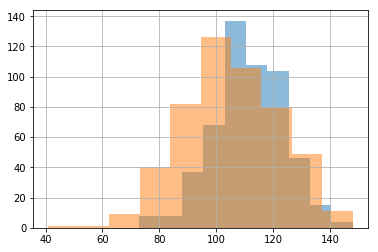

In [339]:
# deal with missing FIQ data:
# check the distribution of full-scale IQ in each diagnostic group (ASD and TD)

pheno['fiq'].groupby(pheno['dx_group']).hist(alpha = 0.5)

In [340]:
# average FIQ in each group

pheno['fiq'].groupby(pheno['dx_group']).mean()

dx_group
0    111.245981
1    105.345743
Name: fiq, dtype: float64

In [141]:
# FIQ appears to be relatively normally distributed in each group, although average IQ is slightly higher in TD
# we can replace missing FIQ values with group-specific means

In [341]:
# replace missing FIQ with group-specific mean

pheno['fiq'] = pheno['fiq'].fillna(pheno.groupby('dx_group')['fiq'].transform('mean'))

In [342]:
# confirm we are no longer missing any phenotypic data

pheno.isnull().sum()

sub_id                 0
site_id                0
file_id                0
dx_group               0
age_at_scan            0
sex                    0
handedness_category    0
fiq                    0
handedness_recode      0
handedness_L           0
handedness_Other       0
handedness_R           0
dtype: int64

In [343]:
# lastly, create a dummy variable for site

site_dummies = pd.get_dummies(pheno['site_id'], prefix = 'site')
pheno = pd.concat([pheno, site_dummies], axis = 1)

In [344]:
pheno.head()

,sub_id,site_id,file_id,dx_group,age_at_scan,sex,handedness_category,fiq,handedness_recode,handedness_L,...,site_SBL,site_SDSU,site_STANFORD,site_TRINITY,site_UCLA_1,site_UCLA_2,site_UM_1,site_UM_2,site_USM,site_YALE
0,50002,PITT,no_filename,1,16.77,1,Ambi,103.0,Other,0,...,0,0,0,0,0,0,0,0,0,0
1,50003,PITT,Pitt_0050003,1,24.45,1,R,124.0,R,0,...,0,0,0,0,0,0,0,0,0,0
2,50004,PITT,Pitt_0050004,1,19.09,1,R,113.0,R,0,...,0,0,0,0,0,0,0,0,0,0
3,50005,PITT,Pitt_0050005,1,13.73,0,R,119.0,R,0,...,0,0,0,0,0,0,0,0,0,0
4,50006,PITT,Pitt_0050006,1,13.37,1,L,109.0,L,1,...,0,0,0,0,0,0,0,0,0,0


In [376]:
# load the structural cortical thickness dataset we compiled with previous script

struct = pd.read_csv('abide_cortical_thickness_20190701.csv')

In [377]:
struct.shape

(1035, 101)

In [378]:
struct.head()

,Unnamed: 0,File,Sub-brick,Mean_4,Mean_5,Mean_6,Mean_7,Mean_10,Mean_11,Mean_12,...,Mean_2025,Mean_2026,Mean_2027,Mean_2028,Mean_2029,Mean_2030,Mean_2031,Mean_2034,Mean_2035,FILE_ID
0,0,/data/Projects/ABIDE_Initiative/Outputs/ants/a...,0[?],0.003061,1.040163,0.140702,0.000009,0.002665,0.0,0.0,...,2.125226,3.498914,2.340307,2.085285,0.950366,1.807719,1.565881,1.833145,3.194357,Pitt_0050003
1,0,/data/Projects/ABIDE_Initiative/Outputs/ants/a...,0[?],0.011357,0.993277,0.083727,0.000042,0.004407,0.0,0.0,...,2.715785,3.871004,2.626445,2.471903,1.558296,2.666532,2.430273,2.103015,4.404319,Pitt_0050004
2,0,/data/Projects/ABIDE_Initiative/Outputs/ants/a...,0[?],0.016591,0.872625,0.078526,0.000014,0.003133,0.0,0.0,...,2.147347,3.228483,2.539060,2.405678,1.354254,1.967489,1.721139,1.411481,3.148464,Pitt_0050005
3,0,/data/Projects/ABIDE_Initiative/Outputs/ants/a...,0[?],0.015656,1.396618,0.110892,0.000022,0.003367,0.0,0.0,...,3.026796,4.073865,2.855339,2.869385,1.870028,2.676286,2.531543,2.043278,3.620175,Pitt_0050006
4,0,/data/Projects/ABIDE_Initiative/Outputs/ants/a...,0[?],0.003159,0.543084,0.087172,0.000004,0.001864,0.0,0.0,...,2.176468,3.241596,2.278591,2.171605,1.151163,1.940420,1.956121,1.299927,2.978172,Pitt_0050007


In [379]:
# remove trailing spaces in column names

struct.columns = struct.columns.str.rstrip()

In [380]:
# drop unneeded columns
# labels < 1002 refer to subcortical areas that are not of interest

struct.drop(columns = ['Unnamed: 0','File','Sub-brick','Mean_4','Mean_5','Mean_6','Mean_7',
                       'Mean_10','Mean_11','Mean_12','Mean_13','Mean_14','Mean_15',
                       'Mean_16','Mean_17','Mean_18','Mean_24','Mean_26','Mean_28',
                       'Mean_30','Mean_43','Mean_44','Mean_45','Mean_46','Mean_49',
                       'Mean_50','Mean_51','Mean_52','Mean_53','Mean_54','Mean_58',
                       'Mean_60','Mean_85','Mean_91','Mean_92','Mean_630','Mean_631',
                       'Mean_632',], inplace = True)

In [362]:
# load file with cortical labels so we can rename columns to be more informative
# source: https://mindboggle.readthedocs.io/en/latest/labels.html

cortical_labels = pd.read_csv('dkt_cortical_labeling.txt', sep = ',', names = ['Num', 'Region'])

In [363]:
cortical_labels.shape

(70, 2)

In [364]:
cortical_labels.head()

,Num,Region
0,1002,"""left caudal anterior cingulate"""
1,1003,"""left caudal middle frontal"""
2,1005,"""left cuneus"""
3,1006,"""left entorhinal"""
4,1007,"""left fusiform"""


In [365]:
# create a list of column names that match the struct dataframe

labels_list = list(cortical_labels['Num'])
ColName = list()

for label in labels_list:
    ColName.append('Mean_' + str(label))

In [366]:
# concatenate the list (as a series) with the cortical_labels dataframe

ColName = pd.Series(ColName)
cortical_labels = pd.concat([cortical_labels, ColName], axis = 1)
cortical_labels.rename(columns = {0:'ColName'}, inplace = True)

In [367]:
# in region names, replace quotes with spaces, replace left/right with L/R, remove preceding spaces, and replace
# spaces with underscores

cortical_labels['Region'] = cortical_labels['Region'].str.replace('"', '')
cortical_labels['Region'] = cortical_labels['Region'].str.replace('left', 'L')
cortical_labels['Region'] = cortical_labels['Region'].str.replace('right', 'R')
cortical_labels['Region'] = cortical_labels['Region'].str.lstrip()
cortical_labels['Region'] = cortical_labels['Region'].str.replace(' ', '_')

In [369]:
# create dictionary of col names and region names so we can rename the column names in the struct dataframe

labels_dict = pd.Series(cortical_labels.Region.values, index = cortical_labels.ColName).to_dict()

In [382]:
#  rename the column names in the struct dataframe

struct.rename(columns = labels_dict, inplace = True)
struct.rename(columns = {'FILE_ID' : 'file_id'}, inplace = True)

In [383]:
struct.head()

,L_caudal_anterior_cingulate,L_caudal_middle_frontal,L_cuneus,L_entorhinal,L_fusiform,L_inferior_parietal,L_inferior_temporal,L_isthmus_cingulate,L_lateral_occipital,L_lateral_orbitofrontal,...,R_precuneus,R_rostral_anterior_cingulate,R_rostral_middle_frontal,R_superior_frontal,R_superior_parietal,R_superior_temporal,R_supramarginal,R_transverse_temporal,R_insula,file_id
0,2.444888,1.743748,1.630556,4.433183,3.438976,1.808027,2.905073,2.579995,1.781040,1.818831,...,2.125226,3.498914,2.340307,2.085285,0.950366,1.807719,1.565881,1.833145,3.194357,Pitt_0050003
1,2.910726,2.117335,1.559899,3.735439,3.318953,2.895951,3.167277,2.802922,2.348444,2.443488,...,2.715785,3.871004,2.626445,2.471903,1.558296,2.666532,2.430273,2.103015,4.404319,Pitt_0050004
2,3.058572,1.732239,1.181260,3.297290,2.678088,2.076877,2.685756,2.795749,1.463868,2.679437,...,2.147347,3.228483,2.539060,2.405678,1.354254,1.967489,1.721139,1.411481,3.148464,Pitt_0050005
3,3.080709,2.375477,1.780259,3.170126,3.584299,2.973735,2.992952,3.038985,2.265689,2.409980,...,3.026796,4.073865,2.855339,2.869385,1.870028,2.676286,2.531543,2.043278,3.620175,Pitt_0050006
4,2.974376,1.828126,1.599866,2.804257,2.633193,1.983200,2.675325,2.553525,1.776191,2.456933,...,2.176468,3.241596,2.278591,2.171605,1.151163,1.940420,1.956121,1.299927,2.978172,Pitt_0050007


In [385]:
# check if any of the columns have missing data

struct.columns[struct.isna().any()].tolist()

[]

In [ ]:
# the list is empty so we can conclude that no columns in the struct dataframe have missing data

In [386]:
# merge the cleaned phenotypic and cortical thickness datasets

compiled = pd.merge(pheno, struct, how = 'inner', on = 'file_id')

In [387]:
compiled.shape

(1035, 94)

In [390]:
compiled.head()

,sub_id,site_id,file_id,dx_group,age_at_scan,sex,handedness_category,fiq,handedness_recode,handedness_L,...,R_precentral,R_precuneus,R_rostral_anterior_cingulate,R_rostral_middle_frontal,R_superior_frontal,R_superior_parietal,R_superior_temporal,R_supramarginal,R_transverse_temporal,R_insula
0,50003,PITT,Pitt_0050003,1,24.45,1,R,124.0,R,0,...,1.201163,2.125226,3.498914,2.340307,2.085285,0.950366,1.807719,1.565881,1.833145,3.194357
1,50004,PITT,Pitt_0050004,1,19.09,1,R,113.0,R,0,...,1.862501,2.715785,3.871004,2.626445,2.471903,1.558296,2.666532,2.430273,2.103015,4.404319
2,50005,PITT,Pitt_0050005,1,13.73,0,R,119.0,R,0,...,1.492682,2.147347,3.228483,2.539060,2.405678,1.354254,1.967489,1.721139,1.411481,3.148464
3,50006,PITT,Pitt_0050006,1,13.37,1,L,109.0,L,1,...,1.973964,3.026796,4.073865,2.855339,2.869385,1.870028,2.676286,2.531543,2.043278,3.620175
4,50007,PITT,Pitt_0050007,1,17.78,1,R,110.0,R,0,...,1.384572,2.176468,3.241596,2.278591,2.171605,1.151163,1.940420,1.956121,1.299927,2.978172


In [389]:
# save the merged/compiled dataset as a CSV file

compiled.to_csv('abide_compiled_data_20190707.csv')